# Data sampler
Creates a set of images that can be used for training a convolutional neural network.

### Input
- Geotiff that will be sampled
- Bounds of the geotiff, geopackage or other geospatial vector format
    - TODO: Just extract the extent from geotiff nodata mask 
- locations of the wanted class, geopackage or other geospatial vector format

### Output
- Two folders with geotiff images inside, one containing images and the other containing labels

### Internal workings
- The known occurrences are oversampled and negative samples are selected randomly.
    -  This ensures that both sample types are represented equally in the created dataset.
- The sampler works well with sparse datasets, where it is relatively rare that the negative samples would contain an unkown occurence
    - Thus there shouldn't be too much misclassifications in the data that would cause problem
- User has the option to set buffer size for the known occurences, because one pixel locations are harder to locate for model than .
### TODO
- Current implementation creates images in order, known occurences first and non-occurences last. This makes shuffling necessary at the model script, which complicates things. Shuffling should be moved to this script
- This sampling script should be integrated to the cnn scripts so that leave one out cross validation would be easy to do
    - The leave one out method should be implented in a way that one feature is completely removed from the occurence data before any sampling is done, and then test data is creaed by sampling the left out feature alone
    - without this it is hard to assess level of overfitting
    - users should be given a clear warning about htis, if the script is published without these changes. Overfitting is nearly unavoidable with low amounts of data so user should be given tools to asess the level of overfitting

In [1]:
import os
import subprocess
import rasterio
import json
import tempfile
import math
import shapely

import pandas as pd
import geopandas as geopd
import numpy as np
import matplotlib.pyplot as plt


from shapely.geometry import Point
from rasterio.mask import mask
from rasterio.plot import show

%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [2]:
def get_features_json(gdf):
    """Parses features from GeoDataFrame in such a manner that rasterio wants them
    """
    return [json.loads(gdf.to_json())['geometry']]

def random_points_in_bounds(polygon, number, seed=None):
    rng = np.random.default_rng(seed=seed)
    minx, miny, maxx, maxy = polygon.bounds
    x = rng.integers( minx, maxx, number )
    y = rng.integers( miny, maxy, number )
    return x, y


In [3]:
# Options
# This is probably large enough image
crop_size = 32
exaggeration_size = 120
# Projections are assumed to be the same

# Mineral occurence locations
occurence_path = "/home/iiro/Documents/Työ/data/EIS_IOCG_target_area_CLB/Primary_data/shps/IOCG_Deps_Prosp_Occs_3.shp"
occurences = geopd.read_file(occurence_path)
# Raster to be sampled, assumed to contain different features at diiferent bands, but also works with just one
test_data_path = "data/possible data/test/important_features.tif"

out_image_dir = "/tmp/images"
out_label_dir = "/tmp/labels"
# Shapefile that gives the bounds of the area
#TODO instead just extract the extent from raster nodata
bounds_path = "/home/iiro/Documents/Työ/data/EIS_IOCG_target_area_CLB/Primary_data/shps/EIS_IOCG_target_area.shp"
bounds = geopd.read_file(bounds_path)

# This should be given as option to the user, None is OK
seed = 1
# The amount of locations that do contain, should be user controlled
random_point_count = 100



if not os.path.isdir(out_image_dir):
    os.mkdir(out_image_dir)
if not os.path.isdir(out_label_dir):
    os.mkdir(out_label_dir)

tmp_root = tempfile.gettempdir()
tmp_dir = os.path.join(tmp_root, "image_patch_generator")
if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)

# Extracting image and necessary information
raster = rasterio.open(test_data_path)
meta = raster.meta.copy()
label_meta = raster.meta.copy()
label_meta['nodata'] = 255
label_meta['count'] = 1
label_meta['dtype'] = 'uint8'
burned_raster_path = os.path.join(tmp_dir, "rasterised.tif")


pixel_size_x, pixel_size_y = raster.res

nodata_mask = raster.read_masks(1)
# nodata mask is useful starting point for creating empty raster where points can be burned
nodata_mask[nodata_mask == 0] = 254

nodata_mask[nodata_mask == 255] = 0
nodata_mask[nodata_mask == 254] = label_meta['nodata']
# converts geodataframe with point geometry to suitable format and converts it to buffered polygon to have larger area
points = [shapely.buffer(Point(x, y), exaggeration_size) for x, y in zip(occurences["geometry"].x, occurences["geometry"].y)]
rasterized = rasterio.features.rasterize(points, out=nodata_mask, transform=meta['transform'])

rasterized[nodata_mask== label_meta['nodata']] = label_meta['nodata']
with rasterio.open(burned_raster_path, "w", **label_meta) as dest:
            dest.write(rasterized, 1)
    
label = rasterio.open(burned_raster_path)

<Axes: >

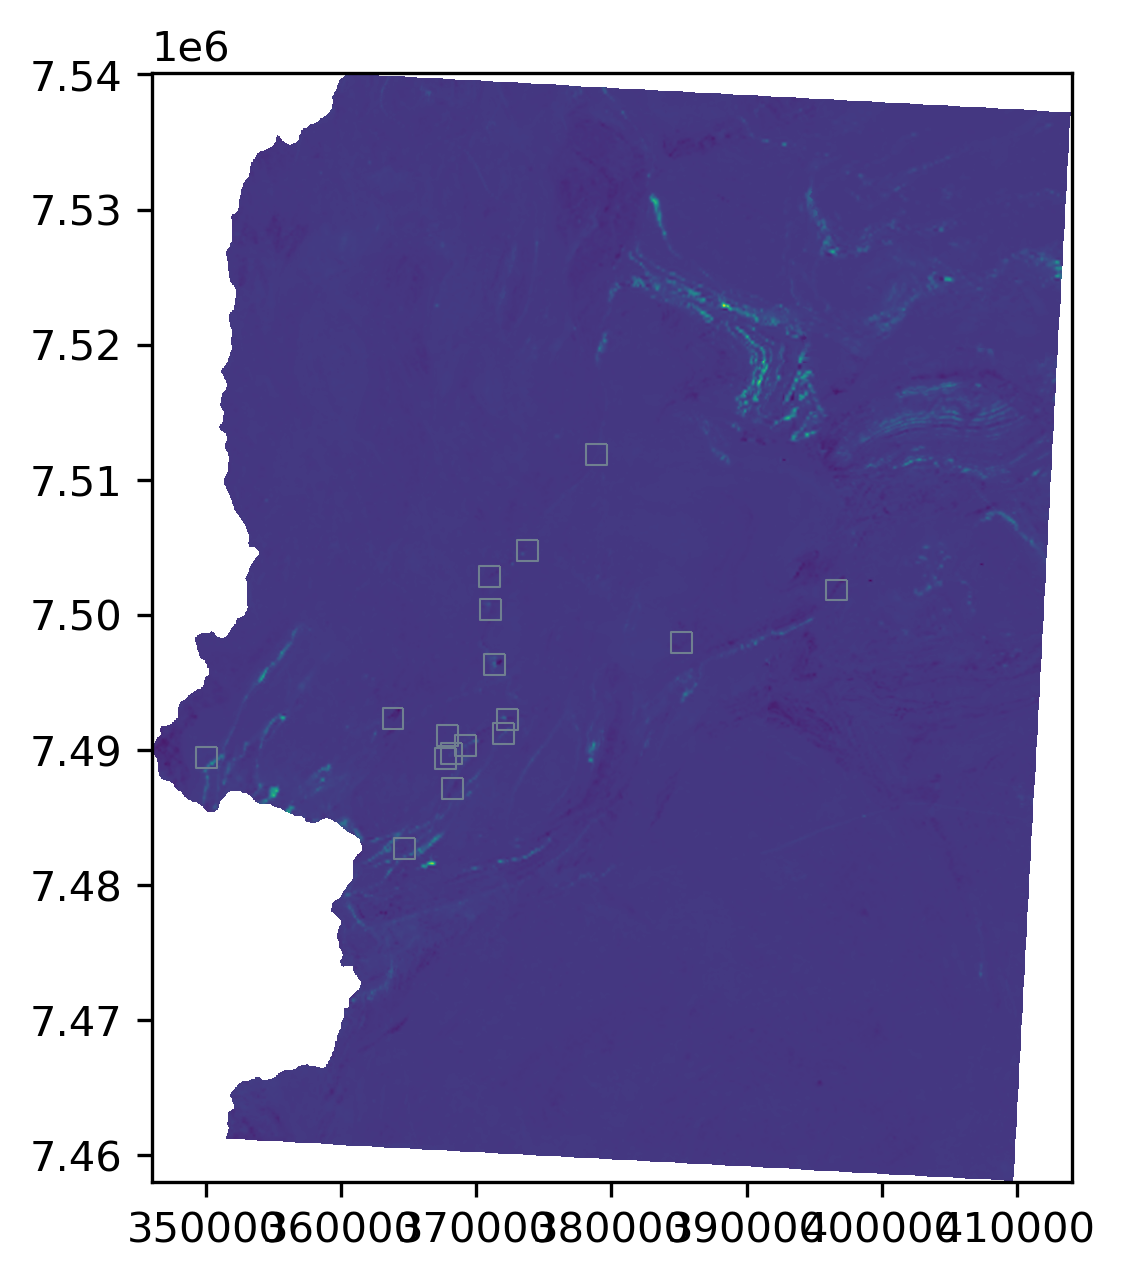

In [4]:
# the pixel size is assumed to be square. option three means doing square buffers
#TODO add support for non-square pixels
buffer = occurences.buffer(((crop_size / 2) * pixel_size_x)-(pixel_size_x/2), cap_style=3)

# for developement purposes
fig, ax1 = plt.subplots()
show(raster, ax=ax1, cmap='viridis')
buffer.boundary.plot(ax=ax1, color = 'slategrey', linewidth=0.5)
#occurences.plot(ax= ax1, color = 'red')

- we also need examples of areas that are different from known occurences

<Axes: >

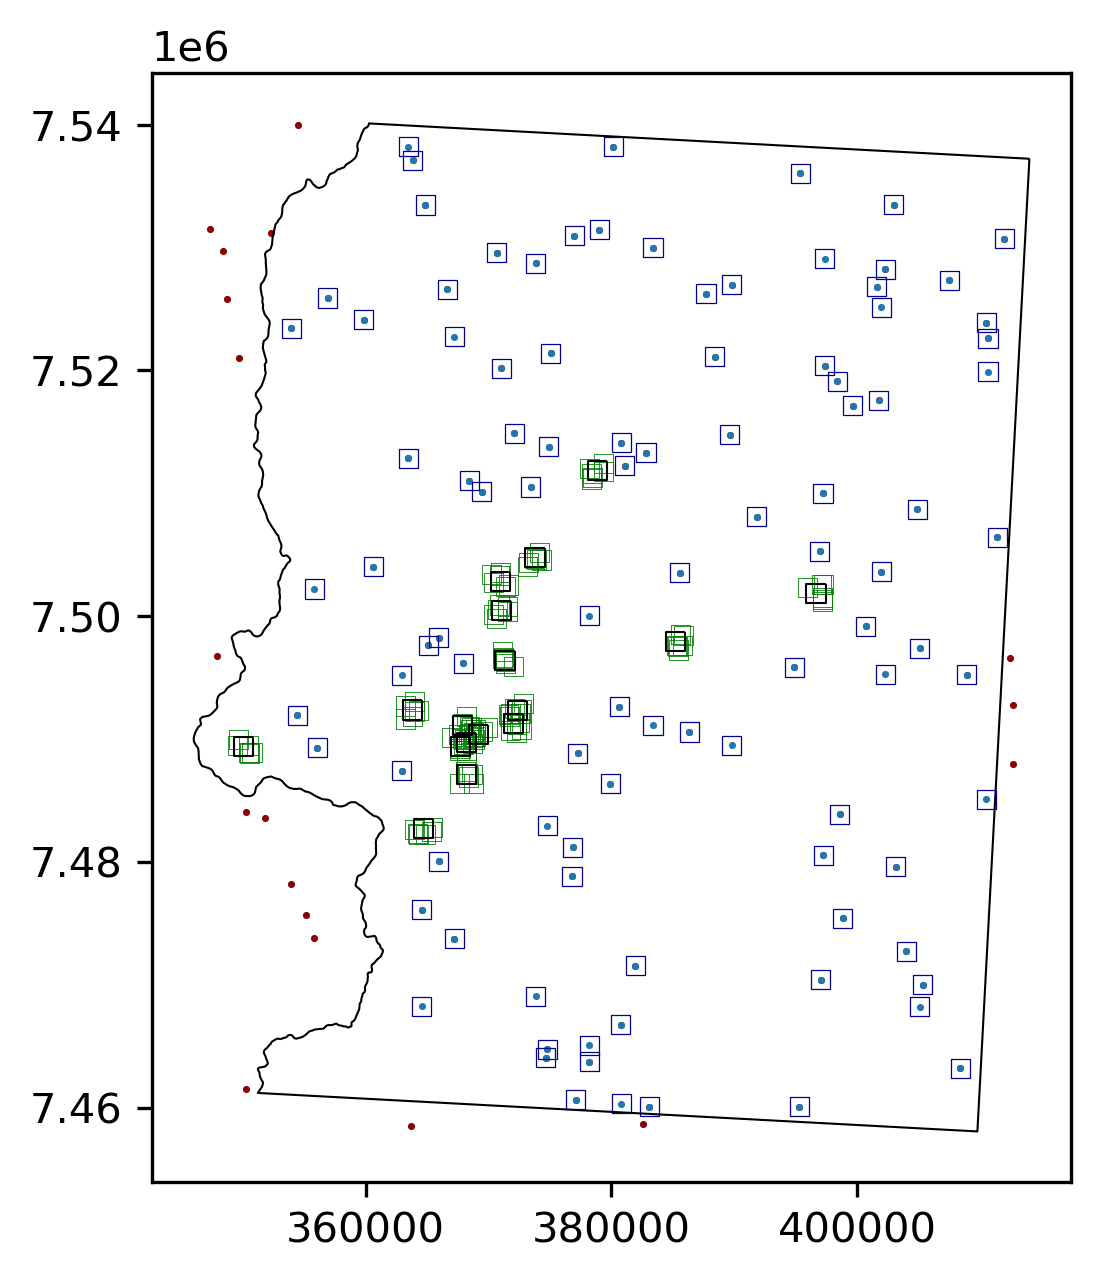

In [5]:

"""TODO current implementation just assumes that mineral occurences are sparse, and thus hitting one in random is unlikely.
Different measurements of similarity such as mahalanobis or som or distance in pca feature space could be considered to be added as options.
It would be good to have variability in the examples that should not include mineral occurences, altough it is likely that random sampling produces good enough results. Some spatial stratification stregies could also be explored
"""
""" Current implementation assumes that there is only one polygon in the bounding geometry
TODO create multi-polygon implementation
"""

# Creating oversamples
# Finding examples of areas that should be different from the known locations.
x_coord, y_coord = random_points_in_bounds(bounds.geometry[0], random_point_count, seed)
df = pd.DataFrame()
df['points'] = list(zip(x_coord,y_coord))
df['points'] = df['points'].apply(Point)
random_points = geopd.GeoDataFrame(df, geometry='points', crs=occurences.crs)

# Finding the geometric difference of bounding polygon and known occurence buffer, to find suitable areas for  the random points
buffer_df = geopd.GeoDataFrame(buffer, geometry=buffer.geometry)
diff = bounds.overlay(buffer_df, how='difference')

# Filtering out the points that fall outside the area or inside known occurencses buffer
sjoin = geopd.tools.sjoin(random_points, diff, predicate="within", how='left')

points_in_poly = random_points[sjoin.index_right==0]
# It is probable that some points are at invalid locations and thus there are not as many as wanted, so they are added until required amount is achieved
while points_in_poly.shape[0] != random_point_count:
    x_coord, y_coord = random_points_in_bounds(bounds.geometry[0], random_point_count - points_in_poly.shape[0], seed)
    df = pd.DataFrame()
    df['points'] = list(zip(x_coord,y_coord))
    df['points'] = df['points'].apply(Point)
    random_points_add = geopd.GeoDataFrame(df, geometry='points', crs=occurences.crs)
    sjoin = geopd.tools.sjoin(random_points_add, diff, predicate="within", how='left')
    added_points = random_points_add[sjoin.index_right==0]
    points_in_poly = pd.concat([points_in_poly, added_points])

random_buffer = points_in_poly.buffer(((crop_size / 2) * pixel_size_x)-(pixel_size_x/2), cap_style=3)

# Random occurences inside the square buffers
random_points_per_patch = math.ceil(random_point_count / len(buffer))
for i, geometry in enumerate(buffer):
    if i == 0:
        x_occ_coord, y_occ_coord = random_points_in_bounds(geometry, random_points_per_patch, seed + i)
    else:
        temp_x, temp_y = random_points_in_bounds(geometry, random_points_per_patch, seed + i)
        x_occ_coord = np.concatenate((x_occ_coord, temp_x))
        y_occ_coord = np.concatenate((y_occ_coord, temp_y))

occ_df = pd.DataFrame()
occ_df['points'] = list(zip(x_occ_coord,y_occ_coord))
occ_df['points'] = occ_df['points'].apply(Point)
random_occurences = geopd.GeoDataFrame(occ_df, geometry='points', crs=occurences.crs)
r_occ_buffer = random_occurences.buffer(((crop_size / 2) * pixel_size_x)-(pixel_size_x/2), cap_style=3)
# for developement purposes
fig, ax = plt.subplots()
bounds.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
r_occ_buffer.boundary.plot(ax=ax, color = 'green', linewidth=0.2)
#random_occurences.plot(ax=ax, markersize=0.1, c='slategrey')
random_points.plot(ax=ax, markersize=0.5, c='darkred')
points_in_poly.plot(ax=ax, markersize=0.5)
buffer.boundary.plot(ax=ax, color = 'black', linewidth=0.5)
random_buffer.boundary.plot(ax=ax, color = 'darkblue', linewidth=0.3)


In [6]:
patch_meta = raster.meta.copy()
patch_meta['height'] = crop_size
patch_meta['width'] = crop_size
patch_meta['count'] = 10

# feature patches
for i, feature in enumerate(r_occ_buffer):
    bbox=[feature]
    out_image, patch_meta['transform']=mask(raster, bbox, all_touched=True, crop=True)
    out_path = os.path.join(out_image_dir, str(i) + '.tif')
    with rasterio.open(out_path, "w", **patch_meta) as dest:
            dest.write(out_image)

# Non-occurence patches
for i, feature in enumerate(random_buffer):
    # without this the real feature patches will be overwritten
    i += len(r_occ_buffer)
    bbox=[feature]
    out_image, patch_meta['transform']=mask(raster, bbox, all_touched=True, crop=True)
    out_path = os.path.join(out_image_dir, str(i) + '.tif')
    with rasterio.open(out_path, "w", **patch_meta) as dest:
            dest.write(out_image)

label_patch_meta = label_meta
label_patch_meta['height'] = crop_size
label_patch_meta['width'] = crop_size
label_patch_meta['count'] = 1
# label patches
for i, feature in enumerate(r_occ_buffer):
    bbox=[feature]
    out_image, label_patch_meta['transform']=mask(label, bbox, all_touched=True, crop=True)
    out_path = os.path.join(out_label_dir, str(i) + '.tif')
    with rasterio.open(out_path, "w", **label_patch_meta) as dest:
            dest.write(out_image)
# non-occurence label patches
for i, feature in enumerate(random_buffer):
    # without this the real feature patches will be overwritten
    i += len(r_occ_buffer)
    bbox=[feature]
    out_image, label_patch_meta['transform']=mask(label, bbox, all_touched=True, crop=True)
    out_path = os.path.join(out_label_dir, str(i) + '.tif')
    with rasterio.open(out_path, "w", **label_patch_meta) as dest:
            dest.write(out_image)

<Axes: >

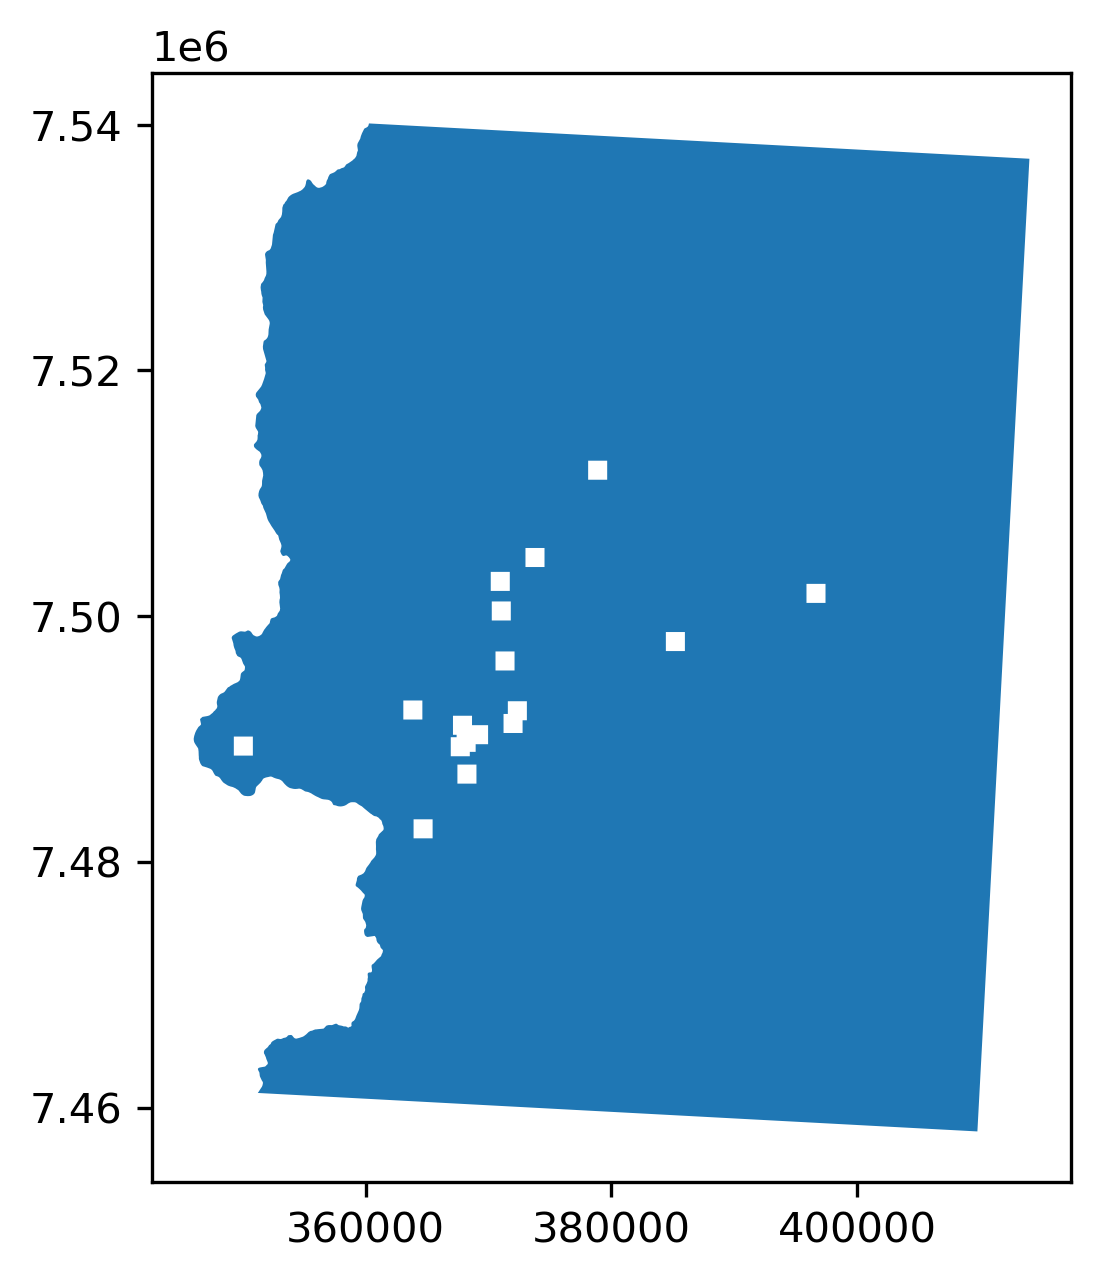

In [7]:
diff.plot()

204